# 4.숫자 분류기
## 4.1 픽셀
### 데이터 읽기

In [1]:
from fastai.vision.all import *
import matplotlib.pyplot as plt

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls() # reture L class which is customed list(python built-in function) by fast.ai

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid')]

In [3]:
(path/"train").ls() # 3 and 7

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

In [4]:
threes = (path/"train"/"3").ls().sorted()  # 숫자 3 이미지들
sevens = (path/"train"/"7").ls().sorted()  # 숫자 7 이미지들

threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

### 이미지

In [5]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3 # using PIL(python Imaging Library)

In [6]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [7]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [8]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{"font-size":"6pt"}).background_gradient("Greys") # 28*28 = 784

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


## 4.2 픽셀 유사성

In [9]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]  # 해당 Path에서 데이터를 읽음
len(three_tensors), len(seven_tensors)

(6131, 6265)

<AxesSubplot:>

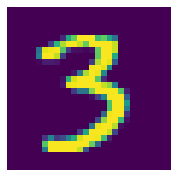

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

show_image(three_tensors[1], ax=ax) # "show_image" function for tensor

In [11]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape # the rank is 3

torch.Size([6131, 28, 28])

<AxesSubplot:>

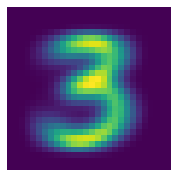

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

mean3 = stacked_threes.mean(0)
show_image(mean3, ax=ax)

<AxesSubplot:>

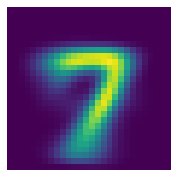

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

mean7 = stacked_sevens.mean(0)
show_image(mean7, ax=ax)

In [14]:
a_3 = stacked_threes[1]

### Loss

In [15]:
dist_3_abs = (a_3 - mean3).abs().mean() # L1 Norm
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() # L2 Norm
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [16]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [17]:
F.l1_loss(a_3, mean7), F.mse_loss(a_3, mean7).sqrt() # torch.nn.functional

(tensor(0.1586), tensor(0.3021))

## 4.3 브로드캐스팅으로 평가지표 계산하기

In [18]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/"valid"/"3").ls()])
valid_3_tens = valid_3_tens.float() / 255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/"valid"/"7").ls()])
valid_7_tens = valid_7_tens.float() / 255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

### 단일 이미지

In [19]:
def mnist_distance(a, b):
    return (a-b).abs().mean((-1, -2))  # 축을 의미(가로, 세로)

mnist_distance(a_3, mean3)

tensor(0.1114)

### 복수 이미지(브로드캐스팅)

In [20]:
valid_3_dist = mnist_distance(valid_7_tens, mean3)  # 브로드캐스팅
valid_3_dist, valid_3_dist.shape

(tensor([0.1922, 0.1915, 0.1488,  ..., 0.1534, 0.1623, 0.1863]),
 torch.Size([1028]))

In [21]:
(valid_7_tens - mean3).shape  # 랭크 낮은 텐서를 높은 텐서로 맞춤

torch.Size([1028, 28, 28])

### 평가

In [22]:
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [23]:
is_3(valid_3_tens)  # 브로드캐스팅

tensor([True, True, True,  ..., True, True, True])

In [24]:
accuracy_3 = is_3(valid_3_tens).float().mean()
accuracy_7 = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3, accuracy_7, (accuracy_3+accuracy_7)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## 4.4 확률적 경사 하강법

### 스칼라

In [25]:
def f(x):
    return x**2

xt = tensor(3.).requires_grad_()

In [26]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [27]:
yt.backward()  # 그레이디언트 계산

In [28]:
xt.grad

tensor(6.)

### 백터

In [29]:
def f(x):
    return (x**2).sum()

xt = tensor([3., 4., 5.]).requires_grad_()
xt

tensor([3., 4., 5.], requires_grad=True)

In [30]:
yt = f(xt)
yt.backward()

In [31]:
xt.grad

tensor([ 6.,  8., 10.])

### SGD 예제

In [32]:
time = torch.arange(0, 20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

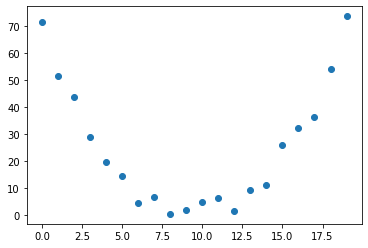

In [33]:
# 데이터 만들기
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [34]:
def f(t, params):  # 가설
    a, b, c = params
    return a * (t**2) + (b*t) + c

In [35]:
def mse(preds, targets):  # 손실함수
    return ((preds-targets)**2).mean().sqrt()

In [36]:
## 임의의 값으로 파라미터 초기화
params = torch.randn(3).requires_grad_()

## 예측 계산
preds = f(time, params)

## 유사도 확인 함수
def show_preds(preds, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color="red")
    ax.set_ylim(-300, 100)

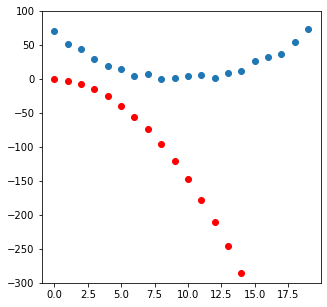

In [37]:
show_preds(preds)

In [38]:
## 손실 계산
loss = mse(preds, speed)
print(loss)

# 그레이디언트 계산
loss.backward()
print(params.grad)

# 가중치 갱신
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

tensor(266.6283, grad_fn=<SqrtBackward0>)
tensor([-166.9842,  -10.7226,   -0.7691])


In [39]:
preds = f(time, params)
mse(preds, speed)

tensor(266.3483, grad_fn=<SqrtBackward0>)

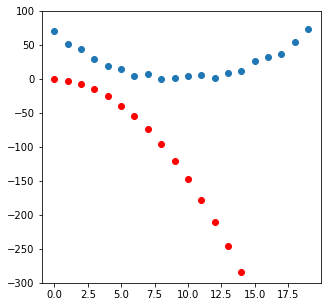

In [40]:
show_preds(preds)

In [41]:
## 과정 반복하기
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    
    if prn:
        print(loss.item())
    return preds

# for i in range(10):
#     apply_step(params)

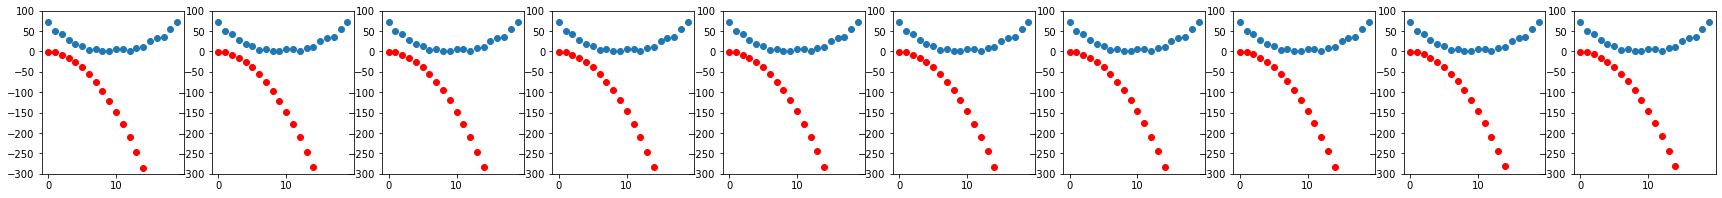

In [42]:
_, axes = plt.subplots(1, 10, figsize=(30, 3))
for ax in axes:
    preds = apply_step(params, prn=False)
    show_preds(preds, ax)

## 4.5 MNIST 손실함수

### Train and validation dataset

In [43]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)  # rank 3 -> 2
train_x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [44]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(dim=1)  # rank 1 -> 2, train_x와 차원이 동일해 짐

In [45]:
dset = list(zip(train_x, train_y))
x, y = dset[0]

x.shape, y

(torch.Size([784]), tensor([1]))

In [46]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

### Initial parameters

In [47]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28), 1)

In [48]:
bias = init_params(1)

### Prediction

In [49]:
(train_x[0] * weights.T).sum() + bias

tensor([-8.9805], grad_fn=<AddBackward0>)

In [50]:
# shape
train_x.shape, weights.shape

(torch.Size([12396, 784]), torch.Size([784]))

In [51]:
def linear1(xb):
    return xb@weights + bias  # 행렬 곱

preds = linear1(train_x)
preds

tensor([-8.9805, -0.1554,  3.1238,  ..., -4.3176,  8.6162,  2.4116],
       grad_fn=<AddBackward0>)

In [52]:
corrects = (preds > 0.5).float() == train_y
corrects

tensor([[False, False,  True,  ..., False,  True,  True],
        [False, False,  True,  ..., False,  True,  True],
        [False, False,  True,  ..., False,  True,  True],
        ...,
        [ True,  True, False,  ...,  True, False, False],
        [ True,  True, False,  ...,  True, False, False],
        [ True,  True, False,  ...,  True, False, False]])

In [53]:
corrects.float().mean().item()  # 정확도, weight가 조금 바뀐다고 해서 정확도가 변화하지는 않으므로 좋은 손실함수로 보긴 어려움

0.49985000491142273

### Loss fuction

In [54]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [55]:
# loss example
targets = tensor([1, 0, 1])
preds = tensor([0.9, 0.4, 0.2])

mnist_loss(preds, targets)

tensor(0.4333)

In [56]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()  # 0 ~ 1

### Minibatch

In [57]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([9, 7, 0, 1, 2]),
 tensor([13, 10, 12, 14,  3]),
 tensor([ 5,  4,  8, 11,  6])]

In [58]:
ds = L(enumerate(string.ascii_lowercase))  # L은 list의 wapper로 보임
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [59]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([22,  9, 13, 16,  7, 21]), ('w', 'j', 'n', 'q', 'h', 'v')),
 (tensor([ 3, 18,  6,  8,  2, 15]), ('d', 's', 'g', 'i', 'c', 'p')),
 (tensor([20, 24, 23,  0,  5, 10]), ('u', 'y', 'x', 'a', 'f', 'k')),
 (tensor([11,  1, 19, 25, 12,  4]), ('l', 'b', 't', 'z', 'm', 'e')),
 (tensor([14, 17]), ('o', 'r'))]

## 4.6 모든 것을 한 자리에

### Snippet

In [60]:
# epoch
# for x, y in dl:
#     pred = model(x)  # not defined yet
#     loss = loss_func(pred, y)
#     loss.backward()
#     parameters -= lr * parameters

# initialize 
weights = init_params((28*28, 1))
bias = init_params(1)

# dataloader
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [61]:
# 크기가 4인 미니배치로 간단한 테스트 하기
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [62]:
preds = linear1(batch)
preds

tensor([[-16.6270],
        [-19.2261],
        [-17.1906],
        [ -8.6423]], grad_fn=<AddBackward0>)

In [63]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(1.0000, grad_fn=<MeanBackward0>)

In [64]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-7.7602e-06), tensor([-4.4131e-05]))

### 함수로 구현하기(핵심 내용)

In [65]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()
            
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [66]:
weights.grad.zero_()  # grad를 누적하기 때문에 미리 0으로 설정해야 함
bias.grad.zero_()

calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad  # 함수 사용 전의 값도 동일함

(tensor(-7.7602e-06), tensor([-4.4131e-05]))

In [67]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [68]:
validate_epoch(linear1)

0.31

In [69]:
# epoch 반복하기

lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4888

In [70]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=" ")

0.4922 0.4932 0.5987 0.6683 0.8485 0.9213 0.9394 0.9481 0.956 0.9613 0.9637 0.9657 0.9657 0.9667 0.9696 0.9706 0.9716 0.9721 0.9721 0.9726 

### Optimizer with nn.module

In [71]:
linear_model = nn.Linear(28*28, 1)  # nn모듈은 학습 파라미터를 내장하고 있음
w, b = linear_model.parameters()  # parameters() 함수로 확인 가능
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [72]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
        
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [73]:
opt = BasicOptim(params=linear_model.parameters(), lr=lr)

In [74]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [75]:
validate_epoch(linear_model)

0.57

In [76]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=" ")

In [77]:
train_model(linear_model, 20)

0.4932 0.7983 0.8496 0.915 0.9341 0.9492 0.956 0.9623 0.9658 0.9672 0.9702 0.9716 0.9731 0.9741 0.976 0.977 0.9775 0.978 0.978 0.979 

### fastai

In [78]:
# SGD 클래스
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7837 0.8594 0.9184 0.935 0.9516 0.957 0.9638 0.9658 0.9677 0.9697 0.9716 0.9741 0.9751 0.976 0.977 0.9775 0.978 0.9785 0.979 

In [79]:
dls = DataLoaders(dl, valid_dl)

In [80]:
learn = Learner(dls,
                nn.Linear(28*28, 1),
                opt_func=SGD,
                loss_func=mnist_loss,
                metrics=batch_accuracy)

In [81]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637160,0.501296,0.495584,00:00
1,0.294361,0.309878,0.684495,00:00
2,0.116841,0.155957,0.860157,00:00
3,0.056637,0.098954,0.917566,00:00
4,0.034020,0.074308,0.935231,00:00
5,0.024858,0.060412,0.948479,00:00
6,0.020888,0.051546,0.956820,00:00
7,0.018981,0.045551,0.963199,00:00
8,0.017915,0.041293,0.965653,00:00
9,0.017210,0.038131,0.966634,00:00


## 4.7 비선형성 추가

In [82]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [83]:
w1 = init_params((28*28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)

In [84]:
simple_net(train_x)

tensor([[46.6994],
        [30.8781],
        [ 8.8109],
        ...,
        [14.7158],
        [54.9547],
        [-0.6796]], grad_fn=<AddBackward0>)

### fastai & torch

In [85]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1),
)

In [86]:
learn = Learner(dls,
                simple_net,
                opt_func=SGD,
                loss_func=mnist_loss,
                metrics=batch_accuracy)

In [87]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.299345,0.413750,0.505397,00:00
1,0.141985,0.223919,0.813543,00:00
2,0.079460,0.113410,0.915604,00:00
3,0.052756,0.076867,0.940137,00:00
4,0.040263,0.060176,0.958783,00:00
5,0.033817,0.050822,0.962218,00:00
6,0.030085,0.044931,0.965653,00:00
7,0.027647,0.040890,0.967615,00:00
8,0.025882,0.037945,0.968106,00:00
9,0.024509,0.035691,0.968597,00:00


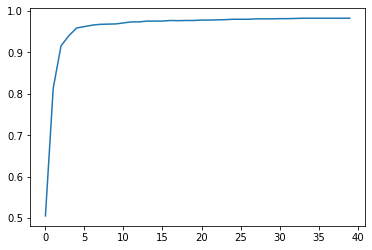

In [88]:
plt.plot(L(learn.recorder.values).itemgot(2))  # 2번째 batch_accuracy만 출력

In [89]:
learn.recorder.values[-1][2]  # 최종 정확도

0.98233562707901

### 깊은 모델

In [90]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.064107,0.010982,0.998037,00:06
